# SVM
将数据集分隔开来的直线称为分隔超平面（separating hyperplane）, 点到分隔面的距离被称为间隔 （margin）本书中有两个间隔的概念：一个是点到分隔面的距离，称为点相对于分隔面的间隔；另一个是数据集中所有点到 分隔面的最小间隔的2倍，称为分类器或数据集的间隔。一般论文书籍中所提到的“间隔”多指后者。SVM分类 器是要找最大的数据集间隔

支持向量（support vector）就是离分隔超平面最近的那些点。接下来要试着最大化支持向量 到分隔面的距离，需要找到此问题的优化求解方法

这里的类别标签采用1和+1，而不是0和1, 这是由于1和+1仅仅相差一个符号， 方便数学上的处理。我们可以通过一个统一公式来表示间隔或者数据点到分隔超平面的距离，同 时不必担心数据到底是属于1还是+1类。

当计算数据点到分隔面的距离并确定分隔面的放置位置时，间隔通过$label * (w^T x+b)$ 来计算，这时就能体现出-1和+1类的好处了。如果数据点处于正方向（即+1类）并且离分隔超平面很远的位置时，$w^T x+b$会是一个很大的正数，同时$label*(w^T x+b)$也会是一个很大的正数。而 如果数据点处于负方向（-1类）并且离分隔超平面很远的位置时，此时由于类别标签为-1，则 $label * (w^T x+b)$ 仍然是一个很大的正数。

### SMO 算法

SMO表示序列最小优 化（Sequential Minimal Optimization）。Platt的SMO算法是将大优化问题分解为多个小优化问题来 求解的。这些小优化问题往往很容易求解，并且对它们进行顺序求解的结果与将它们作为整体来 求解的结果是完全一致的。在结果完全相同的同时，SMO算法的求解时间短很多。

SMO算法的目标是求出一系列alpha和b，一旦求出了这些alpha，就很容易计算出权重向量w 并得到分隔超平面。

SMO算法的工作原理是：每次循环中选择两个alpha进行优化处理。 一旦找到一对合适的 alpha，那么就增大其中一个同时减小另一个。这里所谓的“合适”就是指两个alpha必须要符合 一定的条件，条件之一就是这两个alpha必须要在间隔边界之外，而其第二个条件则是这两个alpha 还没有进行过区间化处理或者不在边界上。

### 应用简化版 SMO 算法处理小规模数据集

简化版代码虽然量少 但执行速度慢。Platt SMO算法中的外循环确定要优化的最佳alpha对。而简化版却会跳过这一部 分，首先在数据集上遍历每一个alpha，然后在剩下的alpha集合中随机选择另一个alpha，从而构建alpha对。这里有一点相当重要，就是我们要同时改变两个alpha。之所以这样做是因为我们有 一个约束条件 $\sum \alpha_{i} \cdot \operatorname{label}^{(i)}=0$ 由于改变一个alpha可能会导致该约束条件失效，因此我们总是同时改变两个alpha。为此，我们将构建一个辅助函数，用于在某个区间范围内随机选择一个整数。同时，我们也 需要另一个辅助函数，用于在数值太大时对其进行调整.

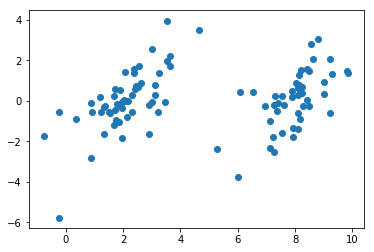

In [17]:
import svmMLiA
dataArr, labelArr = svmMLiA.loadDataSet('testSet.txt')
import matplotlib.pyplot as plt
plt.scatter([x[0] for x in dataArr], [x[1] for x in dataArr])
plt.show()

该SMO函数的伪代码大致如下：

    创建一个alpha向量并将其初始化为0向量 
        当迭代次数小于最大迭代次数时（外循环） 
        对数据集中的每个数据向量（内循环）：
            如果该数据向量可以被优化： 
                随机选择另外一个数据向量 
                同时优化这两个向量 
                如果两个向量都不能被优化，退出内循环 
        如果所有向量都没被优化，增加迭代数目，继续下一次循环
        
#### simple SMO中判断样本是否满足KKT
满足KKT条件的情况：

$\begin{aligned} \alpha_{i} &=0 \Leftrightarrow y_{i} f\left(x_{i}\right) \geq 1 \\ 0<\alpha_{i} &<C \Leftrightarrow y_{i} f\left(x_{i}\right)=1 \\ \alpha_{i} &=C \Leftrightarrow y_{i} f\left(x_{i}\right) \leq 1 \end{aligned}$

$f(x)=\sum_{i=1}^{n} \alpha_{i} y_{i} K\left(x_{i}, x\right)+b$

这里的 y 是训练样本的标签（1 or-1),  $f(x)$是SVM 的预测值。

```
 if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
```

在选择拉格朗日乘子的时候, 优先选择样本前面系数0 < $\alpha_{i}$ <C的$\alpha_{i}$进行优化，因为后面的 $\alpha$小于0或大于C时将被调整为0或C，所以一旦在该 if 语句中 alpha=0 or C 的话，就不再减小增大

所谓的非边界样本就是 $\alpha_{i}$ 不等于边界 0 或 C 的样本，在外层循环中优先选择遍历非边界样本，因为这些样本更有可能需要调整（更有可能违反KKT条件），当其他样本在算法运行中得到优化的时候，非边界样本会移动，而边界样本（$\alpha$ 值等于 0 或者 C）常常留在边界上，由于大部分的数据样本都不可能是支持向量，因此对应的 alpha 乘子ー旦取得 0 值后就无需再进行调整，因为该样本对 f (x）没有任何影响。支撑向量的$\alpha_{i}$ 满足 $0< \alpha_{i} <C$

根据 Osuna 定理，对于任何两个乘子，只要其中一个不满足KKT条件，则我们总能通过双变量二次优化使目标函数减小。SMO 使用 heuristic 的方式寻找乘子对，寻找第一个 $\alpha_{i}$ 构成了 SMO 的外部循环。首先对整个训练集合进行搜索，寻找不满足 KKT 条件的样例。

这里的Ei是真实结果和预测结果的差，所以 $\mathrm{y}[\mathrm{i}] *Ei$ = $\mathrm{y}[\mathrm{i}] * \mathrm{f}[\mathrm{i}] - \mathrm{y}[\mathrm{i}]^2$ =  $\mathrm{y}[\mathrm{i}] * \mathrm{f}[\mathrm{i}] - 1$

又 C 是一个我们指定的大于 0 的值，所以

如果 $\mathrm{y}[\mathrm{i}] *Ei < 0$ , then  $\mathrm{y}[\mathrm{i}] * \mathrm{f}[\mathrm{i}] < 1$ 并且 $\mathrm{\alpha}[\mathrm{i}] < C$ 则不满足KKT，$\mathrm{\alpha}[\mathrm{i}] = C$才满足

如果 $\mathrm{y}[\mathrm{i}] *Ei > 0$ , then  $\mathrm{y}[\mathrm{i}] * \mathrm{f}[\mathrm{i}] > 1$ 并且 $\mathrm{\alpha}[\mathrm{i}] > 0$ 则不满足KKT，$\mathrm{\alpha}[\mathrm{i}] = 0$才满足

代码里面方宽了限制，将0设置为0.6，选择不满足KKT的点进行优化.

```
if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
``` 
#### 统计学习126

$y1 != y2$

$\alpha_{1}^{o l d}-\alpha_{2}^{o l d} = k$  要满足7.102

更新后的

$\alpha_{1}^{new}-\alpha_{2}^{new} = k$

因为

$ 0 \leq \alpha_{1}^{new} \leq C$

$\alpha_{1}^{new}=\alpha_{2}^{new}+k$

$ 0 \leq \alpha_{2}^{new}+k \leq C$

$ -k \leq \alpha_{2}^{new} \leq C - k$ 带入 $\alpha_{1}^{old}-\alpha_{2}^{old} = k$

$ \alpha_{2}^{old}-\alpha_{1}^{old} \leq \alpha_{2}^{new} \leq C + \alpha_{2}^{old}-\alpha_{1}^{old}$ 同时

$ 0 \leq \alpha_{2}^{new} \leq C$

最终得到：

$ \begin{array}{l}{L=\max \left(0, \alpha_{2}^{\text { old }}-\alpha_{1}^{\text { old }}\right)} \\ {H=\min \left(C, C+\alpha_{2}^{\text { old }}-\alpha_{1}^{\text { old }}\right)}\end{array}$

同理，当 y1 == y2时 $\alpha_{1}^{o l d} + \alpha_{2}^{o l d} = k$ 最终得到：

$ \begin{array}{l}{L=\max \left(0, \alpha_{2}^{\text { old }}+ \alpha_{1}^{\text { old }} -C \right)} \\ {H=\min \left(C, \alpha_{2}^{\text { old }} + \alpha_{1}^{\text { old }}\right)}\end{array}$




In [8]:
#要运行几分钟才会收敛
import svmMLiA
from numpy import *
# b, alphas = svmMLiA.smoSimple(dataArr, labelArr, 0.6, 0.001, 40)
# alphas[alphas>0]
# shape(alphas[alphas>0])
# for i in range(100):
#     if alphas[i]>0.0: print(dataArr[i], labelArr[i])

我们可以直接观察alpha矩阵本身，但是其中的零元素太多。为了观察大于0的元素的数量，可以 输入如下命令：由 于 SMO 算 法 的 随 机 性 ， 读 者 运 行 后 所 得 到 的 结 果 可 能 会 与 上 述 结 果 不 同 。 ```alphas[alphas>0]```命令是数组过滤（array filtering）的一个实例，而且它只对NumPy类型有用， 却并不适用于Python中的正则表（regular list）。如果输入alpha>0，那么就会得到一个布尔数组， 并且在不等式成立的情况下，其对应值为正确的。于是，在将该布尔数组应用到原始的矩阵当中 时，就会得到一个NumPy矩阵，并且其中矩阵仅仅包含大于0的值, 大于0的点对应是支撑向量

```
alphas[alphas>0]

matrix([[ 0.12748833,  0.24132866,  0.36881699]])

shape(alphas[alphas>0])

(1, 3)

for i in range(100):
    if alphas[i]>0.0: print(dataArr[i], labelArr[i])
    
[4.658191, 3.507396] -1.0
[3.457096, -0.082216] -1.0
[6.080573, 0.418886] 1.0

```

### 利用完整 Platt SMO 算法加速优化

完整版的 Platt SMO算法。在这两个版本中，实现alpha的更改和代数运算的优化环节一模一样。在优化过 程中，唯一的不同就是选择alpha的方式。完整版的Platt SMO算法应用了一些能够提速的启发方 法。
Platt SMO算法是通过一个外循环来选择第一个alpha值的，并且其选择过程会在两种方式之 间进行交替：一种方式是在所有数据集上进行单遍扫描，另一种方式则是在非边界alpha中实现单遍扫描。而所谓非边界alpha指的就是那些不等于边界0或C的alpha值。对整个数据集的扫描相当容易，而实现非边界alpha值的扫描时，首先需要建立这些alpha值的列表，然后再对这个表进行遍历。同时，该步骤会跳过那些已知的不会改变的alpha值，从而节省时间。

在选择第一个alpha值后，算法会通过一个内循环来选择第二个alpha值。在优化过程中，会 通过最大化步长的方式来获得第二个alpha值。在简化版SMO算法中，我们会在选择j之后计算错 误率Ej。但在这里，我们会建立一个全局的缓存用于保存误差值，并从中选择使得步长或者说 Ei-Ej最大的alpha值。

In [3]:
import svmMLiA
dataArr, labelArr = svmMLiA.loadDataSet('testSet.txt')
b, alphas = svmMLiA.smoPK(dataArr, labelArr, 0.6, 0.001, 40)

常数 C给出的是不同优化问题的权重。常数C一方面要保障所有样例的间隔不小于1.0，另一方面又要 使得分类间隔要尽可能大，并且要在这两方面之间平衡。如果C很大，那么分类器将力图通过分 隔超平面对所有的样例都正确分类。这种优化的运行结果如图6-5所示。与图6-4相比，会发现图 6-5中的支持向量更多。如果回想一下，就会记得图6-4实际来自于简化版算法，该算法是通过随 机的方式选择alpha对的。这种简单的方式也可以工作，但是效果却不如完整版本好，后者覆盖了 整个数据集。读者可能还认为选出的支持向量应该始终最接近分隔超平面。给定C的设置，图中 画圈的支持向量就给出了满足算法的一种解。如果数据集非线性可分，就会发现支持向量会在超 平面附近聚集成团。

### 进行分类

首先必须基于alpha值得到超平面，利用alpha 计算w， 大部分alpha值为0。而非零alpha所对应的也就是支持向量

In [10]:
#计算W
ws = svmMLiA.calcWs(alphas, dataArr, labelArr)
#分类
data = mat(dataArr)
print(data[0] * mat(ws) + b)
print(labelArr[0])
#如果该值大于0，那么其属于1类；如果该值小于0，那么则属于1类。对于数据点0，应该得到的 类别标签是1，可以通过如下的命令来确认分类结果的正确性：

[[-1.10570597]]
-1.0


### 在复杂数据上应用核函数

当数据点处于一个圆中，人类的大脑能够意识到这一点。然而，对于分类器而言， 它只能识别分类器的结果是大于0还是小于0。如果只在x和y轴构成的坐标系中插入直线进行分类 的话，我们并不会得到理想的结果。我们或许可以对圆中的数据进行某种形式的转换，从而得到 某些新的变量来表示数据。在这种表示情况下，我们就更容易得到大于0或者小于0的测试结果。 在这个例子中，我们将数据从一个特征空间转换到另一个特征空间。在新空间下，我们可以很容易利用已有的工具对数据进行处理。数学家们喜欢将这个过程称之为从一个特征空间到另一个特征空间的映射。在通常情况下，这种映射会将低维特征空间映射到高维空间。

这种从某个特征空间到另一个特征空间的映射是通过核函数来实现的。可以把核函数想象成一个包装器（wrapper）或者是接口（interface），它能把数据从某个很难处理的形式转换成 为另一个较容易处理的形式。如果上述特征空间映射的说法听起来很让人迷糊的话，那么可以将 它想象成为另外一种距离计算的方法。前面我们提到过距离计算的方法。距离计算的方法有很多 种，不久我们也将看到，核函数一样具有多种类型。经过空间转换之后，我们可以在高维空间中 解决线性问题，这也就等价于在低维空间中解决非线性问题。

SVM优化中一个特别好的地方就是，所有的运算都可以写成内积（inner product，也称点积） 的形式。向量的内积指的是两个向量相乘，之后得到单个标量或者数值。我们可以把内积运算替 换成核函数，而不必做简化处理。将内积替换成核函数的方式被称为核技巧（kernel trick）或者 核“变电”（kernel substation）。

核函数并不仅仅应用于支持向量机，很多其他的机器学习算法也都用到核函数。接下来，我 们将要来介绍一个流行的核函数，那就是径向基核函数。

##### 径向基函数

径向基函数是SVM中常用的一个核函数。径向基函数是一个采用向量作为自变量的函数，能够基于向量距离运算输出一个标量。这个距离可以是从<0,0>向量或者其他向量开始计算的距离。 接下来，我们将会使用到径向基函数的高斯版本，其具体公式为：

$k(x, y)=\exp \left(\frac{-\|x-y\|^{2}}{2 \sigma^{2}}\right)$

其中， $\sigma$是用户定义的用于确定到达率（reach）或者说函数值跌落到0的速度参数。上述高斯核函数将数据从其特征空间映射到更高维的空间，具体来说这里是映射到一个无穷 维的空间。关于无穷维空间，读者目前不需要太担心。高斯核函数只是一个常用的核函数，使用 者并不需要确切地理解数据到底是如何表现的，而且使用高斯核函数还会得到一个理想的结果。如果碰到了一个不是这种形式的新数据集，使用高斯核函数可以得到很好的结果。当然，该函数也可 以用于许多其他的数据集，并且也能得到低错误率的结果。

添加核函数修改的地方
```
innerL

eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j] #changed for kernel

.....

b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]  #changed for kernel

b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j]- oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]   #changed for kernel
        
def calcEk(oS, k):
    fXk = float(multiply(oS.alphas,oS.labelMat).T*oS.K[:,k] + oS.b) #changed for kernel
    Ek = fXk - float(oS.labelMat[k]) 
    return Ek
```

In [ ]:
import svmMLiA
svmMLiA.testRbf()

### 小结

支持向量的数目存在一个最优值。SVM的优点在于它能对数据进行高效分类。如果支持向量太少，就可能会得到一个很差的决策边界；如果支持向量太多，也就 相当于每次都利用整个数据集进行分类，这种分类方法称为k近邻。

支持向量机是一种分类器。之所以称为“机”是因为它会产生一个二值决策结果，即它是一种 决策“机”。支持向量机的泛化错误率较低，也就是说它具有良好的学习能力，且学到的结果具有 很好的推广性。这些优点使得支持向量机十分流行，有些人认为它是监督学习中最好的定式算法。

支持向量机试图通过求解一个二次优化问题来最大化分类间隔。John Platt引入了SMO算法，此算法可以通过每次只 优化2个alpha值来加快SVM的训练速度。本章首先讨论了一个简化版本所实现的SMO优化过程，接着给出了完整的Platt SMO算法。相对于简化版而言，完整版算法不仅大大地提高了优化的速 度，还使其存在一些进一步提高运行速度的空间。有关这方面的工作，一个经常被引用的参考文 献就是“Improvements to Platt’s SMO Algorithm for SVM Classifier Design” 。

核方法或者说核技巧会将数据（有时是非线性数据）从一个低维空间映射到一个高维空间， 可以将一个在低维空间中的非线性问题转换成高维空间下的线性问题来求解。核方法不止在SVM 中适用，还可以用于其他算法中。而其中的径向基函数是一个常用的度量两个向量距离的核函数。

支持向量机是一个二类分类器。当用其解决多类问题时，则需要额外的方法对其进行扩展。 SVM的效果也对优化参数和所用核函数中的参数敏感。

### 疑问？
C参数的作用